Курсовая работа

02. Регрессия для IC50

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 386.6/386.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 15.4 MB/s eta 0:00:00


In [ ]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 5.4 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import joblib
import optuna
import pickle
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

In [ ]:
# Загрузка  данных
df_standardscaler = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Classic_ML_Vo_PJ/df_standardscaler.csv')

In [ ]:
# Выведим размерность датафрейма
df_standardscaler.shape

(969, 188)

In [ ]:
# Выведим первые строки датафрейма
df_standardscaler.head()

,IC50,CC50,SI,MaxAbsEStateIndex,MaxEStateIndex,MinAbsEStateIndex,MinEStateIndex,qed,SPS,MolWt,...,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiophene,fr_unbrch_alkane,fr_urea
0,-0.599333,-0.648886,0.023693,-1.766931,-1.766931,1.230105,0.859969,-0.751719,1.076111,0.260487,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
1,-0.623447,-0.917447,-0.258103,-2.112017,-2.112017,2.098636,0.953566,-0.540135,1.257528,0.292155,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
2,0.360199,-0.671529,-0.341875,-2.518530,-2.518530,2.154087,0.959542,-1.485466,1.017293,0.748665,...,6.379466,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,2.268081,-0.085302
3,-0.619328,-0.755671,0.492044,-1.765937,-1.765937,1.250111,0.862125,-0.937063,0.991464,0.370656,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,3.080565,-0.085302
4,-0.154375,-0.706065,-0.334138,-1.749744,-1.749744,0.538633,0.785453,-0.696952,0.567012,0.905000,...,-0.179370,-0.211946,-0.111979,-0.096825,-0.032141,-0.032141,-0.238132,-0.274721,-0.169372,-0.085302


In [ ]:
# Выбираем целевую переменную (IC50) и признаки для модели
y = df_standardscaler['IC50']  # Целевая переменная
X = df_standardscaler.drop(columns=['SI', 'CC50', 'IC50'])  # Признаки

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Словарь с классами регрессоров, которые будем оптимизировать
REGRESSORS = {
    'XGBRegressor': XGBRegressor,
    'DecisionTreeRegressor': DecisionTreeRegressor,
    'RandomForestRegressor': RandomForestRegressor,
    'CatBoostRegressor': CatBoostRegressor
}

def objective(trial, regressor_name):
    """Оптимизация гиперпараметров."""
    if regressor_name == 'XGBRegressor':
        params = {
            'objective': 'reg:squarederror',
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'max_depth': trial.suggest_int('max_depth', 3, 15),
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'subsample': trial.suggest_float('subsample', 0.5, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        }
        model = XGBRegressor(**params)

    elif regressor_name == 'DecisionTreeRegressor':
        params = {
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = DecisionTreeRegressor(**params)

    elif regressor_name == 'RandomForestRegressor':
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 50, 550),
            'max_depth': trial.suggest_int('max_depth', 1, 15),
            'min_samples_split': trial.suggest_int('min_samples_split', 2, 10),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
        }
        model = RandomForestRegressor(**params)

    elif regressor_name == 'CatBoostRegressor':
        params = {
            'learning_rate': trial.suggest_float('learning_rate', 1e-4, 1.0, log=True),
            'depth': trial.suggest_int('depth', 1, 10),
            'iterations': trial.suggest_int('iterations', 50, 550),
            'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-4, 10, log=True),
            'verbose': 0
        }
        model = CatBoostRegressor(**params)
    # Обучаем модель и делаем предсказания
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Оцениваем качество по метрике MSE
    mse = mean_squared_error(y_test, y_pred)
    return mse

# Результаты лучшей модели для каждого алгоритма
best_models = {}
for regressor_name in REGRESSORS.keys():
    print(f"Оптимизация гиперпараметров для {regressor_name}...")
    study = optuna.create_study(direction='minimize')  # Минимизация MSE
    study.optimize(lambda trial: objective(trial, regressor_name), n_trials=200)
    # Получаем лучший набор параметров
    best_trial = study.best_trial
    best_model = REGRESSORS[regressor_name](**best_trial.params).fit(X_train, y_train)
    best_models[regressor_name] = {
        'best_params': best_trial.params,
        'best_model': best_model,
    }

    print(f"Оптимальные гиперпараметры для {regressor_name}:", best_trial.params)

# Оценка качества моделей на тестовых данных
for regressor_name, model_data in best_models.items():
    best_model = model_data['best_model']
    y_test_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_test_pred)
    mae = mean_absolute_error(y_test, y_test_pred)
    r2 = r2_score(y_test, y_test_pred)

    print(f"{regressor_name} - Тестовый MSE: {mse}, Тестовый MAE: {mae}, Тестовый R^2: {r2}")

[I 2025-06-09 14:31:34,519] A new study created in memory with name: no-name-4f481554-78ad-4ad6-a645-d4664857593f


Оптимизация гиперпараметров для XGBRegressor...


[I 2025-06-09 14:32:06,557] Trial 0 finished with value: 1.127154057000643 and parameters: {'learning_rate': 0.0011887518681116412, 'max_depth': 15, 'n_estimators': 401, 'subsample': 0.9502906220547092, 'colsample_bytree': 0.758523809334495}. Best is trial 0 with value: 1.127154057000643.
[I 2025-06-09 14:32:09,518] Trial 1 finished with value: 2.8551884555738662 and parameters: {'learning_rate': 0.9977179922995912, 'max_depth': 5, 'n_estimators': 321, 'subsample': 0.5434978935190373, 'colsample_bytree': 0.600189824543373}. Best is trial 0 with value: 1.127154057000643.
[I 2025-06-09 14:32:42,745] Trial 2 finished with value: 1.1158996122561193 and parameters: {'learning_rate': 0.0011423537820347703, 'max_depth': 11, 'n_estimators': 545, 'subsample': 0.8545705983650491, 'colsample_bytree': 0.716206652135819}. Best is trial 2 with value: 1.1158996122561193.
[I 2025-06-09 14:32:45,987] Trial 3 finished with value: 1.0949788066796997 and parameters: {'learning_rate': 0.0027171916666687158

Оптимальные гиперпараметры для XGBRegressor: {'learning_rate': 0.030813778044256994, 'max_depth': 3, 'n_estimators': 104, 'subsample': 0.9913998353435839, 'colsample_bytree': 0.5602758268610387}
Оптимизация гиперпараметров для DecisionTreeRegressor...


[I 2025-06-09 14:41:03,882] Trial 3 finished with value: 1.3958596370000764 and parameters: {'max_depth': 13, 'min_samples_split': 6, 'min_samples_leaf': 6}. Best is trial 1 with value: 1.346997736821191.
[I 2025-06-09 14:41:03,924] Trial 4 finished with value: 1.3764020428065677 and parameters: {'max_depth': 6, 'min_samples_split': 8, 'min_samples_leaf': 4}. Best is trial 1 with value: 1.346997736821191.
[I 2025-06-09 14:41:03,993] Trial 5 finished with value: 1.5653687198822281 and parameters: {'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 2}. Best is trial 1 with value: 1.346997736821191.
[I 2025-06-09 14:41:04,030] Trial 6 finished with value: 1.1712886677856185 and parameters: {'max_depth': 5, 'min_samples_split': 8, 'min_samples_leaf': 8}. Best is trial 6 with value: 1.1712886677856185.
[I 2025-06-09 14:41:04,067] Trial 7 finished with value: 1.303806962384962 and parameters: {'max_depth': 5, 'min_samples_split': 10, 'min_samples_leaf': 6}. Best is trial 6 with val

Оптимальные гиперпараметры для DecisionTreeRegressor: {'max_depth': 3, 'min_samples_split': 7, 'min_samples_leaf': 8}
Оптимизация гиперпараметров для RandomForestRegressor...


[I 2025-06-09 14:41:16,142] Trial 0 finished with value: 1.1651302445654925 and parameters: {'n_estimators': 204, 'max_depth': 1, 'min_samples_split': 7, 'min_samples_leaf': 3}. Best is trial 0 with value: 1.1651302445654925.
[I 2025-06-09 14:41:19,422] Trial 1 finished with value: 1.1774632718074134 and parameters: {'n_estimators': 485, 'max_depth': 1, 'min_samples_split': 2, 'min_samples_leaf': 1}. Best is trial 0 with value: 1.1651302445654925.
[I 2025-06-09 14:41:22,014] Trial 2 finished with value: 1.106379039356237 and parameters: {'n_estimators': 180, 'max_depth': 3, 'min_samples_split': 3, 'min_samples_leaf': 2}. Best is trial 2 with value: 1.106379039356237.
[I 2025-06-09 14:41:33,459] Trial 3 finished with value: 1.060945085232496 and parameters: {'n_estimators': 356, 'max_depth': 10, 'min_samples_split': 8, 'min_samples_leaf': 9}. Best is trial 3 with value: 1.060945085232496.
[I 2025-06-09 14:41:35,124] Trial 4 finished with value: 1.087029396218584 and parameters: {'n_esti

Оптимальные гиперпараметры для RandomForestRegressor: {'n_estimators': 443, 'max_depth': 12, 'min_samples_split': 4, 'min_samples_leaf': 10}
Оптимизация гиперпараметров для CatBoostRegressor...


[I 2025-06-09 15:24:09,526] Trial 0 finished with value: 1.2174362496356093 and parameters: {'learning_rate': 0.00012789041592564714, 'depth': 9, 'iterations': 135, 'l2_leaf_reg': 0.0003088113933206596}. Best is trial 0 with value: 1.2174362496356093.
[I 2025-06-09 15:24:10,330] Trial 1 finished with value: 1.2186962718383945 and parameters: {'learning_rate': 0.00020869492861111825, 'depth': 3, 'iterations': 147, 'l2_leaf_reg': 2.0393995705739796}. Best is trial 0 with value: 1.2174362496356093.
[I 2025-06-09 15:24:11,940] Trial 2 finished with value: 1.2134476236084044 and parameters: {'learning_rate': 0.0002769169089757612, 'depth': 4, 'iterations': 206, 'l2_leaf_reg': 0.0001271261648865193}. Best is trial 2 with value: 1.2134476236084044.
[I 2025-06-09 15:24:16,114] Trial 3 finished with value: 1.198909624105991 and parameters: {'learning_rate': 0.05559702230698833, 'depth': 3, 'iterations': 416, 'l2_leaf_reg': 0.001581668055053619}. Best is trial 3 with value: 1.198909624105991.
[I

0:	learn: 0.9591407	total: 29.5ms	remaining: 7.89s
1:	learn: 0.9566132	total: 54.2ms	remaining: 7.23s
2:	learn: 0.9533301	total: 86.4ms	remaining: 7.66s
3:	learn: 0.9498075	total: 120ms	remaining: 7.96s
4:	learn: 0.9463895	total: 149ms	remaining: 7.86s
5:	learn: 0.9431248	total: 177ms	remaining: 7.77s
6:	learn: 0.9409325	total: 204ms	remaining: 7.64s
7:	learn: 0.9390071	total: 233ms	remaining: 7.61s
8:	learn: 0.9366923	total: 255ms	remaining: 7.38s
9:	learn: 0.9339162	total: 281ms	remaining: 7.26s
10:	learn: 0.9315660	total: 309ms	remaining: 7.25s
11:	learn: 0.9272137	total: 335ms	remaining: 7.17s
12:	learn: 0.9253041	total: 364ms	remaining: 7.17s
13:	learn: 0.9224897	total: 392ms	remaining: 7.14s
14:	learn: 0.9203012	total: 419ms	remaining: 7.09s
15:	learn: 0.9183943	total: 451ms	remaining: 7.13s
16:	learn: 0.9158455	total: 478ms	remaining: 7.08s
17:	learn: 0.9126002	total: 505ms	remaining: 7.05s
18:	learn: 0.9096684	total: 538ms	remaining: 7.08s
19:	learn: 0.9075298	total: 573ms	rema

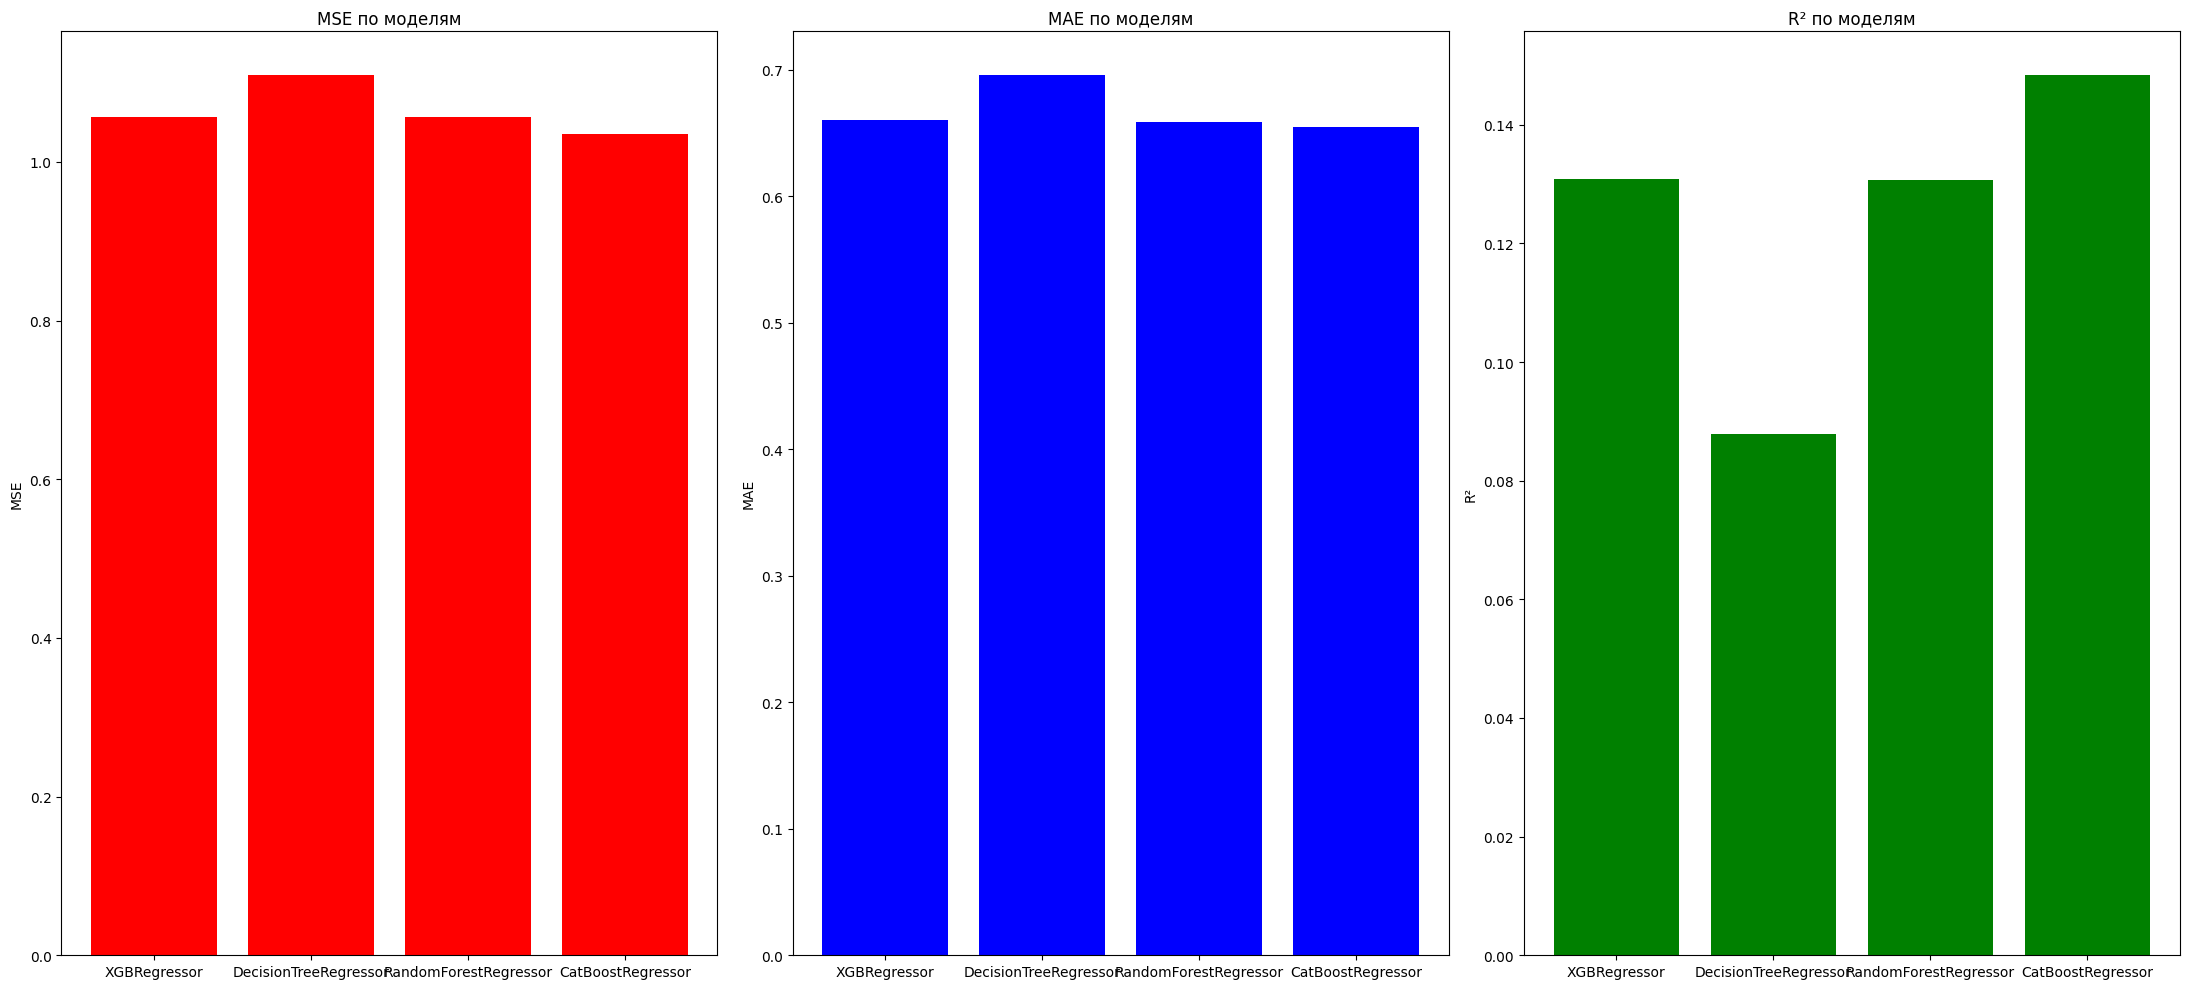

In [ ]:
# Сравненим качество регрессионных моделей с визуализацией результатов
def plot_results(models_metrics):
    model_names = list(models_metrics.keys())
    mse_values = [metrics[0] for metrics in models_metrics.values()]
    mae_values = [metrics[1] for metrics in models_metrics.values()]
    r2_values = [metrics[2] for metrics in models_metrics.values()]

    plt.figure(figsize=(22, 10))

    # График 1: MSE по моделям
    plt.subplot(1, 3, 1)
    plt.bar(model_names, mse_values, color='red')
    plt.title('MSE по моделям')
    plt.ylabel('MSE')

    # График 2: MAE по моделям
    plt.subplot(1, 3, 2)
    plt.bar(model_names, mae_values, color='blue')
    plt.title('MAE по моделям')
    plt.ylabel('MAE')

    # График 3: R² по моделям
    plt.subplot(1, 3, 3)
    plt.bar(model_names, r2_values, color='green')
    plt.title('R² по моделям')
    plt.ylabel('R²')

    plt.tight_layout()
    plt.show()

# Создадим словарь с метриками для каждой модели
metrics_dict = {name: (mse, mae, r2) for name, (mse, mae, r2) in zip(best_models.keys(), [(mean_squared_error(y_test, model_data['best_model'].predict(X_test)),
                       mean_absolute_error(y_test, model_data['best_model'].predict(X_test)),
                       r2_score(y_test, model_data['best_model'].predict(X_test)) ) for model_data in best_models.values()])}

plot_results(metrics_dict)

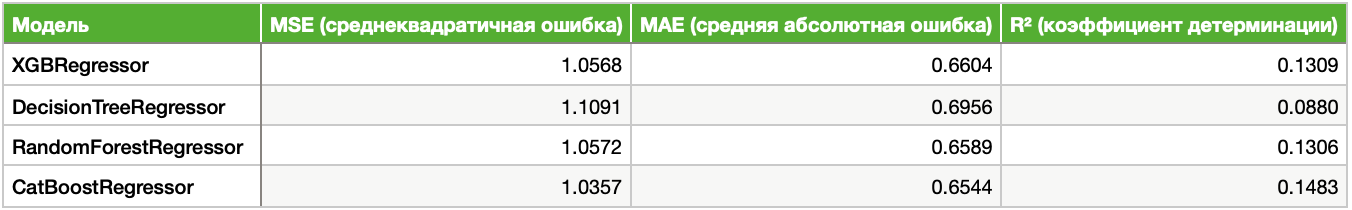


Основные выводы

1. CatBoostRegressor показывает наилучшие результаты
Имеет минимальный MSE , что указывает на наименьшую среднеквадратичную ошибку предсказаний .
Также имеет лучший R² , что говорит о немного лучшей способности модели объяснять вариацию целевой переменной IC50 .
MAE также близок к минимальному, что подтверждает стабильность модели.

 Вывод: CatBoostRegressor — самая точная модель из всех тестированных.

2. XGBoost и Random Forest имеют схожее качество
По всем метрикам они находятся в очень тесной конкуренции .
Разница между ними незначительна , особенно по R² и MAE.
Это может говорить о том, что обе модели одинаково хорошо подходят для задачи.

 Вывод: XGBoost и Random Forest демонстрируют сопоставимое качество.

3. DecisionTreeRegressor хуже остальных моделей
У неё наивысший MSE и MAE , а R² самый низкий .
Это может быть связано с переобучением или недостаточной сложностью модели.
Простые деревья решений могут не улавливать сложные зависимости в данных.

 Вывод: DecisionTreeRegressor не рекомендуется использовать как основную модель в данной задаче.

4. Гиперпараметры CatBoostRegressor оказались оптимальными

Лучшие параметры:

learning_rate = 0.021

depth = 5

iterations = 269

l2_leaf_reg = 0.19

Эти значения обеспечивают хороший баланс между скоростью обучения и качеством предсказаний , что делает модель надежной и эффективной.

5. Все модели показывают низкие значения R²
Все модели имеют R² < 0.2, что указывает на то, что модели не очень хорошо объясняют вариацию целевой переменной.


In [ ]:
# Цикл для сохранения обученных моделей в файлы формата .pkl
for regressor_name, model_data in best_models.items():
    # Формируем имя файла на основе названия модели и целевой переменной (IC50)
    filename = f"{regressor_name}_IC50.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model_data['best_model'], file)
        print(f"Модель '{filename}' сохранена.")

# Загрузка модели из созданного pickle файла
def load_model(regressor_name):
    # Формируем имя файла на основе названия модели и целевой переменной
    filename = f"{regressor_name}_IC50.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
    return model

# Загрузка сохранённых моделей
loaded_xgb = load_model('XGBRegressor')           # XGBoost модель
loaded_dt = load_model('DecisionTreeRegressor')   # Дерево решений
loaded_rf = load_model('RandomForestRegressor')   # Случайный лес
loaded_catboost = load_model('CatBoostRegressor') # CatBoost модель

Модель 'XGBRegressor_IC50.pkl' сохранена.
Модель 'DecisionTreeRegressor_IC50.pkl' сохранена.
Модель 'RandomForestRegressor_IC50.pkl' сохранена.
Модель 'CatBoostRegressor_IC50.pkl' сохранена.


In [ ]:
# Проверка загруженной модели
y_test_pred = loaded_catboost.predict(X_test)  # Делаем предсказания на тестовой выборке с помощью загруженной модели
mse_loaded = mean_squared_error(y_test, y_test_pred)  # Вычисляем MSE (среднеквадратичную ошибку)
r2_loaded = r2_score(y_test, y_test_pred)  # Вычисляем R² (коэффициент детерминации)

print(f"CatBoostRegressor - Тестовые метрики после загрузки:")
print(f"  MSE: {mse_loaded:.4f}")
print(f"  R²: {r2_loaded:.4f}")

CatBoostRegressor - Тестовые метрики после загрузки:
  MSE: 1.0357
  R²: 0.1483


In [ ]:
import os
# Проверяем все файлы в текущей директории
os.listdir()

['.config',
 'CatBoostRegressor_IC50.pkl',
 'regression_results.md',
 'catboost_info',
 'RandomForestRegressor_IC50.pkl',
 'DecisionTreeRegressor_IC50.pkl',
 'drive',
 'XGBRegressor_IC50.pkl',
 'sample_data']